# Классификация извержения вулкана с помощью нейронных сетей


# 1. Problem Statement
Необходимо по снимкам с веб-камеры определять происходит в данный момент извержение вулкана или нет. 
Если да, то какая активность зафиксирована.
Если видимости нет, то почему - ночь, облачно, туман.

## Libraries and Functions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
# Common libraries
import os
import random
from glob import glob
from imutils import paths
from os import path
import re

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Visualisation
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

# Configure visualisations
%matplotlib inline
mpl.style.use('ggplot')
plt.rcParams["axes.grid"] = False

# Modeling Algorithms
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import load_model
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, recall_score, f1_score, precision_score
from sklearn.metrics import plot_roc_curve 
from sklearn.metrics import confusion_matrix 

print(tf.__version__)
print(tf.executing_eagerly())


2.4.1
True


In [ ]:
project_path = '/content/drive/MyDrive/ML/Volcano/'
IMG_SIZE = (256, 256)
class_status = {0: 'alert', 
               1: 'normal'}

class_pillar = {0: '-', 
               1: 'pillar'}

class_lava = {0: '-', 
              1: 'lava'}   

In [98]:
# Загрузка изображения и приведение к общему размеру 
def load_image(path, target_size=IMG_SIZE):
    image = cv2.imread(path)[...,::-1]
    image = cv2.resize(image, target_size)
    return image  

# Обработка изображения - размерность не меняется
def gradient_image(src):
    image = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    image = cv2.GaussianBlur(image, (3, 3), 0)
    ##laplacian = cv2.Laplacian(image,cv2.CV_64F)
    sobelx = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=5)
    abs_grad_x = cv2.convertScaleAbs(sobelx)
    abs_grad_y = cv2.convertScaleAbs(sobely)    
    image = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0) 
    
    return image 

# Вывод заданного количества изображений из указанной папки    # не используется?
def show_images(imagePaths, nrows = 1, ncols = 5):
  fig = plt.figure(figsize=(16, 8))
  for i, path in enumerate(imagePaths, 1):
      subplot = fig.add_subplot(nrows, ncols, i)
      subplot.set_title('%s' % path.split('/')[-2])
      img = cv2.imread(path)[...,::-1]
      img = cv2.resize(img, IMG_SIZE)
      plt.axis('off')
      plt.imshow(img)


# Вывод заданного количества изображений для генератора
def show_images_gen(generator, nrows = 1, ncols = 5):
  fig = plt.figure(figsize=(16, 8))
  for i, path in enumerate(generator[0][0:nrows*ncols],1) :
      subplot = fig.add_subplot(nrows, ncols, i)
      subplot.set_title(class_status.get(generator[1][i]))
      img = generator[0][i]
      plt.axis('off')
      plt.imshow(img)

# Вывод заданного количества изображений для генератора классов
def show_images_gen_class(generator, nrows = 1, ncols = 5):
  fig = plt.figure(figsize=(16, 8))
  for i, path in enumerate(generator[0][0:nrows*ncols],1) :
      subplot = fig.add_subplot(nrows, ncols, i)
      title = 'pillar:%s lava:%s \nclear:%s cloud:%s mist:%s' % (class_pillar.get(generator[1][i][0]), class_lava.get(generator[1][i][1]),  generator[1][i][2],generator[1][i][3],generator[1][i][4])
      subplot.set_title(title, fontsize=8)
      img = generator[0][i]
      plt.axis('off')
      plt.imshow(img)


# Вывод изображения заданного количества картинок из пердсказания модели: класс и вероятность отнесения к классу
def show_images_predict(test_files,y_pred, nrows = 1, ncols = 5):
    n_img = nrows*ncols
    fig = plt.figure(figsize=(20, 6))
    for i, (path, score) in enumerate(zip(test_files[0:n_img], y_pred[0:n_img]), 1):
        title = '%s: %s' % (class_status.get(int(round(score[0]))), np.round(score[0],3))
        subplot = fig.add_subplot(nrows, ncols, i)
        subplot.set_title(title, fontsize=8)
        img = cv2.imread(path)[...,::-1]
        img = cv2.resize(img, IMG_SIZE)
        subplot.imshow(img)
        plt.axis('off')
        
# Вывод изображения заданного количества картинок из пердсказания модели: класс и вероятность отнесения к классу
def show_images_predict_class(test_files,y_pred, nrows = 1, ncols = 5):
    n_img = nrows*ncols
    fig = plt.figure(figsize=(25, 10))
    for i, (path, score) in enumerate(zip(test_files[0:n_img], y_pred[0:n_img]), 1):
        title = 'pillar:%s lava:%s \nclear:%s cloud:%s mist:%s' % (np.round(score[0],3),np.round(score[1],3),  np.round(score[2],3), np.round(score[3],3), np.round(score[4],3))
        subplot = fig.add_subplot(nrows, ncols, i)
        subplot.set_title(title, fontsize=8)
        img = cv2.imread(path)[...,::-1]
        img = cv2.resize(img, IMG_SIZE)
        subplot.imshow(img)
        plt.axis('off')


def plot_model_history(model_history):
      # Getting the accuracy and loss
      acc = model_history.history['accuracy']
      val_acc = model_history.history['val_accuracy']
      loss = model_history.history['loss']
      val_loss = model_history.history['val_loss']
      # Plotting the accuracy
      epochs = range(len(acc))

      fig = plt.figure(figsize=(16, 6))
      subplot = fig.add_subplot(1, 2, 1)
      subplot.set_title('accuracy')
      plt.plot(epochs, acc, '-o', label='Training accuracy')
      plt.plot(epochs, val_acc, '-', label='Validation accuracy')
      plt.title('Training and validation accuracy')
      plt.grid(linestyle='--')
      plt.legend()

      subplot = fig.add_subplot(1, 2, 2)
      subplot.set_title('loss')
      plt.plot(epochs, loss, '-o', label='Training Loss' )
      plt.plot(epochs, val_loss, '-', label='Validation Loss')
      plt.title('Training and validation loss')
      plt.legend()
      plt.grid(linestyle='--')
      plt.show()

# функция-генератор загрузки обучающих данных с диска      не используется больше
def fit_generator(files, batch_size=24):   #  долго обучается 1 
    batch_size = min(batch_size, len(files))
    while True:
        random.shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1 if  path.split(os.path.sep)[-2] == 'normal' else 0
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки обучающих данных с диска
def fit_generator_binary_class(files, class_name='status', batch_size=24):   
    batch_size = min(batch_size, len(files))
    while True:
        random.shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y_status = np.array([1 if  path.split(os.path.sep)[-2] == 'normal' else 0    
                          for path in files[i:j]])

            y_pillar, y_lava, y_activity = encode(files[i:j])

            if class_name == 'status': y = y_status
            if class_name == 'pillar': y = np.array(y_pillar)
            if class_name == 'lava':   y = np.array(y_lava)

            yield (x, y)

# функция-генератор загрузки обучающих данных с диска
def fit_generator_classes(files, batch_size=24):   
    batch_size = min(batch_size, len(files))
    while True:
        random.shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1 if  path.split(os.path.sep)[-2] == 'normal' else 0   
                          for path in files[i:j]])

            y_pillar, y_lava, y_activity = encode(files[i:j])

            yield (x, np.array(y_activity))

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

def encode(files_path):
    y_visible = []   # класс видимость категориальный признак (mist, cloud,clear)   
    y_pillar = []    # класс тип активности: 1 - парогазовый столб
    y_lava = []      # класс тип активности: 1 - лава
    y_activity = []  # обощенные признаки всех классов  - pillar	lava	visible__clear	visible__cloud	visible__mist
    for path in files_path:
              result_vis = re.match(r'[a-zA-Z]+', path.split(os.path.sep)[-1])  
              y_visible.append( result_vis.group(0))

              result = re.split(r'\+', path.split(os.path.sep)[-1])
              if result[1] == 'pillar': y_pillar.append(1) 
              else: y_pillar.append(0)
              if result[2] == 'lava': y_lava.append(1) 
              else: y_lava.append(0) 

              y_activity = pd.DataFrame()
              y_activity['pillar'] = y_pillar
              y_activity['lava'] = y_lava
              y_activity = y_activity.join(pd.get_dummies(y_visible, prefix='visible_'))
              y_activity = np.array(y_activity)
              
    return y_pillar, y_lava, y_activity

def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap='Blues') # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)


# 2. Data Understanding

Набор данных - фотографии вуканов, разделенные на несколько классов:

•	класс состояние: 

'**alert**' (0) -  на фото зафиксирована любая активность на вулкане: парогазовый столб, взрыв, потоки лавы, 

'**normal**' (1) - нормальное состояние, никакой активности вулкана не отмечается, либо видимость не позволяет определить более точно. 

•	класс видимость: 

*	**clear** – ясно 
*	**cloud** – облачно 
*	**mist** – туман, сумерки, плохая видимость

•	класс выбросов - **парогазовый столб** (шлейф): 

* 0 / 1 – не определено / определено наличие парогазовых выбросов

•	класс выбросов -  **лава**:

*	 0 / 1 - не определено / определено наличие лавовых потоков.


### 2.1 Загрузка данных

Подготовим три датасета. 
Датасеты для обучения и вализации разбиты на классы. Класс соответствует названию папки.
Датасет для теста не разбит по классам.

In [ ]:
# данные читаем функцией-генератором

imagePaths_train = sorted(list(paths.list_images(path.join(project_path,'data/processed/train'))))
imagePaths_validation = sorted(list(paths.list_images(path.join(project_path,'data/processed/test'))))
imagePaths_test = sorted(list(paths.list_images(path.join(project_path,'data/raw/img'))))


random.shuffle(imagePaths_train)  # перемешиваем обучающую выборку
random.shuffle(imagePaths_validation)

# бинарная классификация
validation_ds = fit_generator_binary_class(imagePaths_train, 'status')
train_ds = fit_generator_binary_class(imagePaths_validation, 'status')  
test_ds = predict_generator(imagePaths_test)

# множественная классификация
train_ds_classes = fit_generator_classes(imagePaths_train)  
validation_ds_classes = fit_generator_classes(imagePaths_validation)

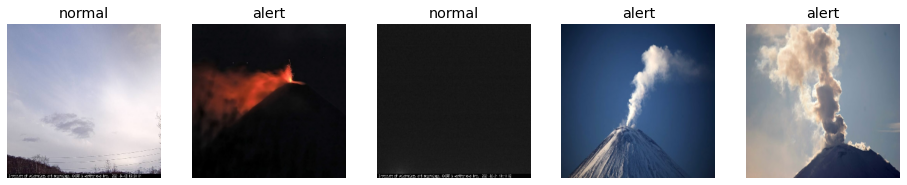

In [ ]:
show_images_gen(next(train_ds),1,5)

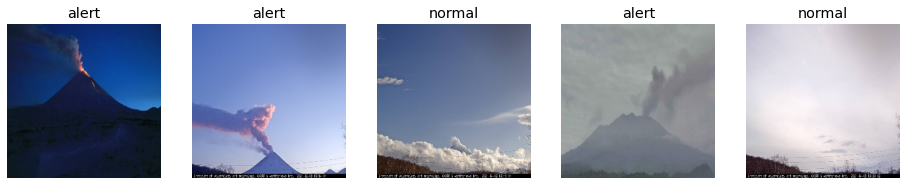

In [ ]:
show_images_gen(next(validation_ds),1,5)

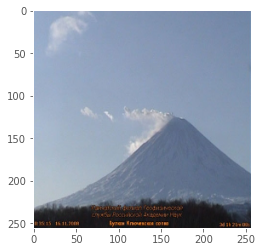

In [ ]:
plt.imshow(next(test_ds)[0])

### 2.2 Анализ данных

Для анализа данных пробуем использовать различные фильтры, переводим в различные цветовые схемы. 

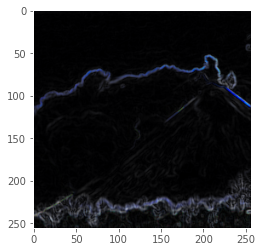

In [ ]:
src = cv2.GaussianBlur(next(train_ds)[0][0], (3, 3), 0)
laplacian = cv2.Laplacian(src,cv2.CV_64F)
src = cv2.cvtColor(src, cv2.COLOR_BGR2HSV)  
sobelx = cv2.Sobel(src,cv2.CV_64F,1,0,ksize=3)
sobely = cv2.Sobel(src,cv2.CV_64F,0,1,ksize=3)
abs_grad_x = cv2.convertScaleAbs(sobelx)
abs_grad_y = cv2.convertScaleAbs(sobely)
    
grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0) 
grad = cv2.cvtColor(grad, cv2.COLOR_HSV2BGR)  
plt.imshow(grad)

In [ ]:
grad.shape

(256, 256, 3)

#  3.  Data Preparation

В данном разделе проводится анализ использования нейронных сетей без дополнительных преобразований изображений, кроме изменения размера. 

# 4. Modeling 

С помощью нейронных сетей построим модели бинарной и множественной классификации для определения состояния вулкана. 
С помощью бинарной определим есть активность или нет. 
С помощью множественной будем определять вероятность каждого из возможных состояний вулкана и условий съемки.
Для обеих задач классификации будем использовать предобученные сеть ResNet50 и VGG16 и веса imagenet.




## 4.1 Бинарная классификация
Для начала определим зафиксирована или нет активность на вулкане, т.е. решим задачу бинарной классификации.

Без весов

In [ ]:
input_img1 = tf.keras.layers.Input(shape=(256, 256, 3))


x1 = tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(input_img1)
x1 = tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(x1)
x1 = tf.keras.layers.GaussianNoise(3)(x1)
x1 = tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(x1)
x1 = tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(x1)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(.2, input_shape=(2,))(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.keras.layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x1)
x1 = tf.keras.layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.keras.layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x1)
x1 = tf.keras.layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x1)
x1 = tf.keras.layers.Dropout(.2, input_shape=(2,))(x1)

x1 = tf.keras.layers.BatchNormalization()(x1)

x1 = tf.keras.layers.Flatten()(x1)

x_class1 = tf.keras.layers.Dense(1,  
                          activation='sigmoid',   
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x1)

model = tf.keras.Model([input_img1], [x_class1])
model.compile(optimizer='rmsprop', loss=['mse', 'binary_crossentropy'], metrics=['accuracy'])
model.summary()

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history_model =  model.fit(train_ds, epochs=30, steps_per_epoch=80, validation_data=validation_ds, callbacks=[es_callback], validation_steps=1)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 128)     3584      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 128)     147584    
_________________________________________________________________
gaussian_noise (GaussianNois (None, 256, 256, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 128)     147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 128)     147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 128)     0     

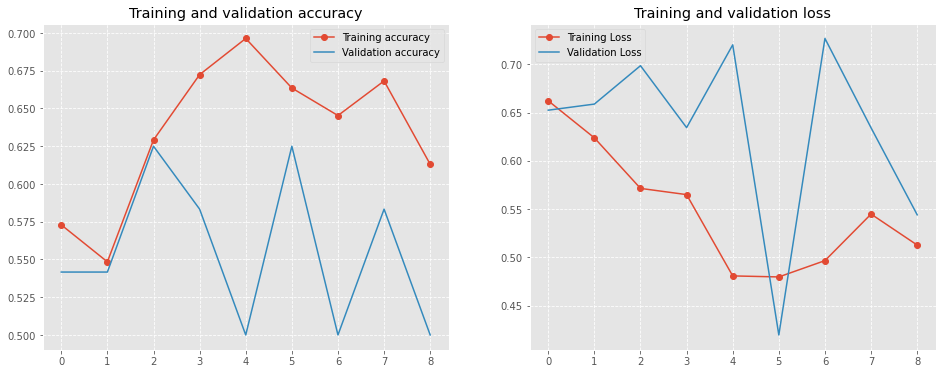

In [ ]:
plot_model_history(history_model)

In [ ]:
test_pred_model = model.predict(predict_generator(imagePaths_test), steps=len(imagePaths_test))
test_pred_model

array([[0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [1.19588e-38],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00],
       [0.00000e+00]], dtype=flo

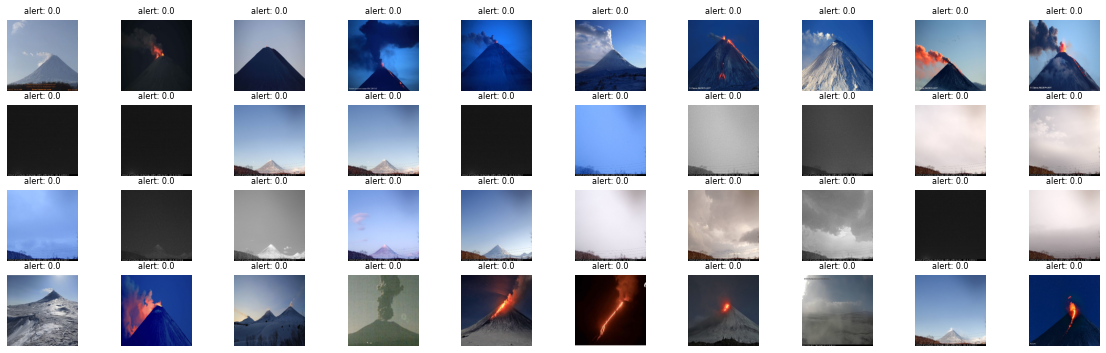

In [ ]:
show_images_predict(imagePaths_test,test_pred_model, 4,  10)

### ResNet50

In [ ]:
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3), classes=2) 

for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Dropout(.2, input_shape=(2,))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Dense(32, activation = 'relu')(x)
x = tf.keras.layers.Dense(32, activation = 'relu')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1,  
                          activation='sigmoid',   
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

ResNet_model_status =  tf.keras.Model(inputs = base_model.input, outputs=x)

ResNet_model_status.compile(optimizer='adam', loss=['mse', 'binary_crossentropy'], metrics=['accuracy'])


94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
ResNet_model_status.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history_ResNet_model_status = ResNet_model_status.fit(train_ds, epochs=30, steps_per_epoch=80, callbacks=[es_callback], validation_data=validation_ds, validation_steps=2)  

Epoch 1/30
80/80 [==============================] - 37s 422ms/step - loss: 0.0293 - accuracy: 0.9584 - val_loss: 0.0962 - val_accuracy: 0.8958
Epoch 2/30
80/80 [==============================] - 33s 418ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.1185 - val_accuracy: 0.8333
Epoch 3/30
80/80 [==============================] - 33s 420ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0593 - val_accuracy: 0.9375
Epoch 4/30
80/80 [==============================] - 33s 410ms/step - loss: 9.6690e-04 - accuracy: 1.0000 - val_loss: 0.0908 - val_accuracy: 0.8750
Epoch 5/30
80/80 [==============================] - 33s 420ms/step - loss: 9.3821e-04 - accuracy: 1.0000 - val_loss: 0.1195 - val_accuracy: 0.8542
Epoch 6/30
80/80 [==============================] - 33s 416ms/step - loss: 8.9583e-04 - accuracy: 1.0000 - val_loss: 0.0791 - val_accuracy: 0.9167


In [75]:
test_pred_ResNet_model_status = ResNet_model_status.predict(predict_generator(imagePaths_test), steps=len(imagePaths_test))
test_pred_ResNet_model_status

array([[0.14709306],
       [0.00129146],
       [0.01279286],
       [0.04170598],
       [0.00264946],
       [0.01672772],
       [0.01475143],
       [0.15033473],
       [0.09826001],
       [0.00997385],
       [0.9999287 ],
       [0.9999697 ],
       [0.0771343 ],
       [0.05294459],
       [0.9999497 ],
       [0.999747  ],
       [0.99928457],
       [0.99992156],
       [0.99930704],
       [0.9997813 ],
       [0.99990416],
       [0.99977523],
       [0.6107317 ],
       [0.8511825 ],
       [0.02300691],
       [0.99947387],
       [0.99678934],
       [0.99386096],
       [0.9998965 ],
       [0.9994765 ],
       [0.15956852],
       [0.00162299],
       [0.05166752],
       [0.03237358],
       [0.00907965],
       [0.01084338],
       [0.00810143],
       [0.70239305],
       [0.00190873],
       [0.00246537],
       [0.18549894],
       [0.9963791 ],
       [0.9999107 ],
       [0.9986702 ],
       [0.99893016]], dtype=float32)

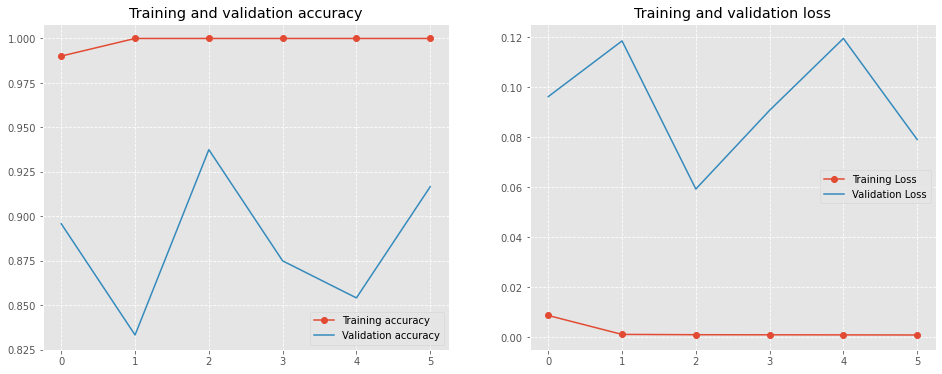

In [ ]:
plot_model_history(history_ResNet_model_status)

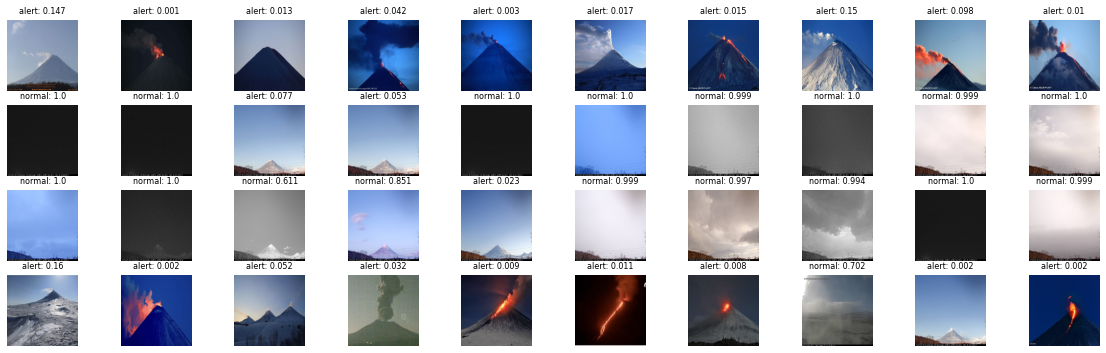

In [ ]:
show_images_predict(imagePaths_test,test_pred_ResNet_model_status, 4,  10)

In [ ]:
ResNet_model_status.save(path.join(project_path,'models/resnet_model_status.h5'))

ResNet50 без дополнительных слоев

In [ ]:
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3), classes=2) 

for layer in base_model.layers:
    layer.trainable = False


x = base_model.layers[-1].output

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1, 
                          activation='sigmoid',    
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

ResNet_model =  tf.keras.Model(inputs = base_model.input, outputs=x)

ResNet_model.compile(optimizer='adam', loss=['mse', 'binary_crossentropy'], metrics=['accuracy'])


In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history_ResNet_model = ResNet_model.fit(train_ds, epochs=30, steps_per_epoch=80, callbacks=[es_callback], validation_data=validation_ds, validation_steps=2)  

Epoch 1/30
80/80 [==============================] - 37s 430ms/step - loss: 0.1384 - accuracy: 0.8899 - val_loss: 0.1522 - val_accuracy: 0.8958
Epoch 2/30
80/80 [==============================] - 33s 420ms/step - loss: 0.1157 - accuracy: 0.9288 - val_loss: 0.0575 - val_accuracy: 0.9792
Epoch 3/30
80/80 [==============================] - 33s 416ms/step - loss: 0.0973 - accuracy: 0.9351 - val_loss: 0.0846 - val_accuracy: 0.9375
Epoch 4/30
80/80 [==============================] - 33s 413ms/step - loss: 0.0835 - accuracy: 0.9359 - val_loss: 0.1207 - val_accuracy: 0.8750
Epoch 5/30
80/80 [==============================] - 33s 413ms/step - loss: 0.0998 - accuracy: 0.9172 - val_loss: 0.2497 - val_accuracy: 0.8125


In [ ]:
test_pred_ResNet_model = ResNet_model.predict(predict_generator(imagePaths_test), steps=len(imagePaths_test))
test_pred_ResNet_model

array([[3.1993602e-04],
       [9.2617441e-35],
       [3.6883458e-18],
       [9.9999833e-01],
       [3.8283435e-26],
       [1.6291269e-16],
       [9.1812507e-07],
       [8.9494126e-05],
       [5.5261711e-07],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [2.6729475e-21],
       [1.7165667e-28],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [2.5434901e-10],
       [2.0735681e-03],
       [5.0613084e-13],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.2398075e-08],
       [6.0017844e-23],
       [7.2131242e-12],
       [9.4369505e-11],
       [2.6045598e-23],
       [1.2257851e-02],
       [1.0810934e-14],
       [9.9999952e-01],
       [0.0000000e+00],
       [9.2243731e-01],
       [1.0181352e-08],
       [1.000000

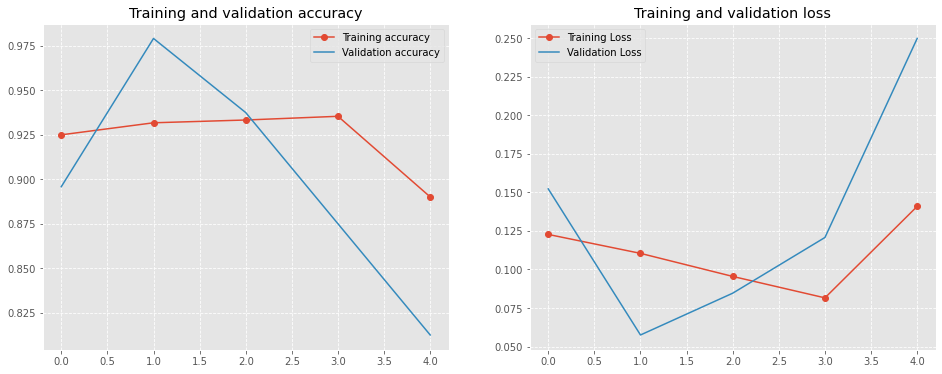

In [ ]:
plot_model_history(history_ResNet_model)

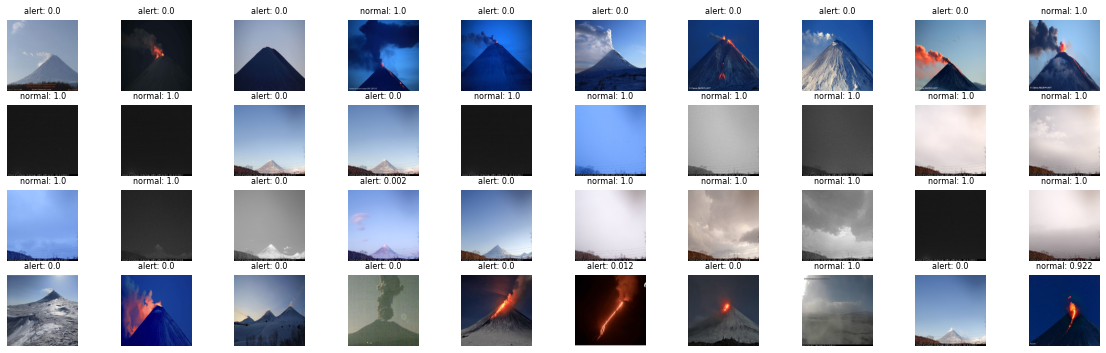

In [ ]:
show_images_predict(imagePaths_test,test_pred_ResNet_model, 4,  10)

### VGG19

In [ ]:
base_model_VGG = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3), classes=2) 

for layer in base_model.layers:
    layer.trainable = False

x = base_model_VGG.layers[-1].output

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1,  
                          activation='sigmoid',   
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

VGG_model_status =  tf.keras.Model(inputs = base_model_VGG.input, outputs=x)

VGG_model_status.compile(optimizer='adam', loss=['mse', 'binary_crossentropy'], metrics=['accuracy'])
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history_VGG = VGG_model_status.fit(train_ds, epochs=30, steps_per_epoch=80, callbacks=[es_callback], validation_data=validation_ds, validation_steps=2)  

80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/30
80/80 [==============================] - 57s 574ms/step - loss: 0.1341 - accuracy: 0.8554 - val_loss: 0.2213 - val_accuracy: 0.7917
Epoch 2/30
80/80 [==============================] - 45s 568ms/step - loss: 0.0203 - accuracy: 0.9931 - val_loss: 0.1827 - val_accuracy: 0.8125
Epoch 3/30
80/80 [==============================] - 45s 567ms/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 0.1590 - val_accuracy: 0.8542
Epoch 4/30
80/80 [==============================] - 45s 567ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.1617 - val_accuracy: 0.8125
Epoch 5/30
80/80 [==============================] - 45s 562ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.0974 - val_accuracy: 0.8750
Epoch 6/30
80/80 [==============================] - 45s 568ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.1824 - val_accuracy: 0.7917
Epoch 7/30
80/80 [==============================] - 45s 565ms/step - loss: 0.

In [81]:
test_pred_VGG_model_status = VGG_model_status.predict(predict_generator(imagePaths_test), steps=len(imagePaths_test))
test_pred_VGG_model_status


array([[0.08234083],
       [0.00354587],
       [0.05491399],
       [0.02559078],
       [0.01018589],
       [0.01121668],
       [0.2153034 ],
       [0.06674786],
       [0.02003616],
       [0.08887661],
       [0.99883324],
       [0.9985562 ],
       [0.00700493],
       [0.00572126],
       [0.9986426 ],
       [0.99949455],
       [0.98852646],
       [0.99657494],
       [0.984132  ],
       [0.98161066],
       [0.9994735 ],
       [0.9949321 ],
       [0.5804206 ],
       [0.22765572],
       [0.12350323],
       [0.9902457 ],
       [0.9949256 ],
       [0.9926621 ],
       [0.9987613 ],
       [0.98770416],
       [0.03652551],
       [0.00239473],
       [0.04856819],
       [0.01146865],
       [0.00992208],
       [0.37248322],
       [0.00498546],
       [0.27944797],
       [0.00326137],
       [0.00324117],
       [0.9993284 ],
       [0.98774827],
       [0.99833953],
       [0.99673444],
       [0.8019429 ]], dtype=float32)

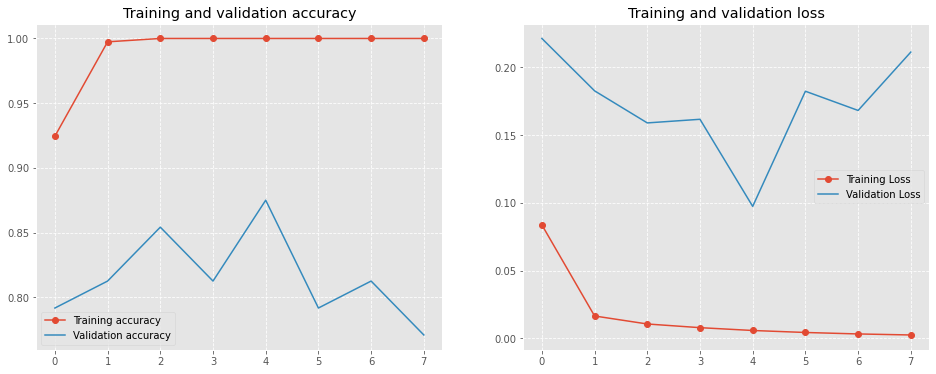

In [ ]:
plot_model_history(history_VGG)

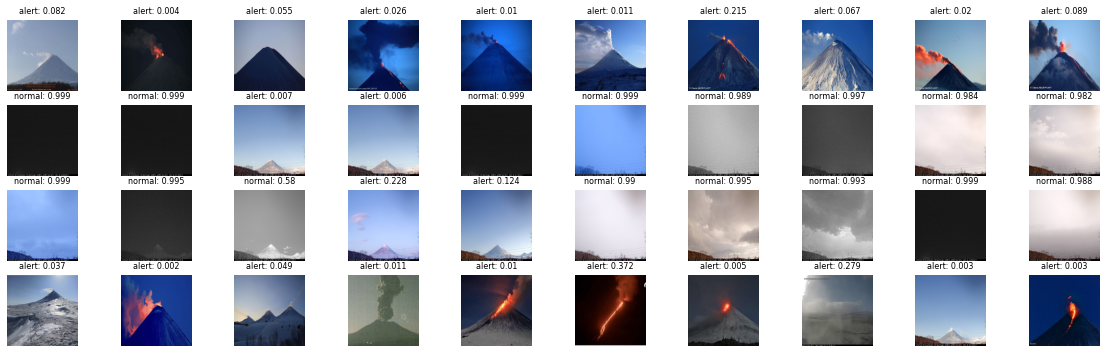

In [78]:
show_images_predict(imagePaths_test,test_pred_VGG_model, 4,  10)

In [ ]:
base_model_VGG = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3), classes=2) 

for layer in base_model_VGG.layers:
    layer.trainable = False


x = base_model_VGG.layers[-5].output
x = tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Dropout(.2, input_shape=(2,))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Dense(32, activation = 'relu')(x)
x = tf.keras.layers.Dense(32, activation = 'relu')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(1,  
                          activation='sigmoid',  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

VGG_model_status =  tf.keras.Model(inputs = base_model_VGG.input, outputs=x)

VGG_model_status.compile(optimizer='adam', loss=['mse', 'binary_crossentropy'], metrics=['accuracy'])
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history_VGG_model_status = VGG_model_status.fit(train_ds, epochs=30, steps_per_epoch=80, callbacks=[es_callback], validation_data=validation_ds, validation_steps=2)  

Epoch 1/30
80/80 [==============================] - 37s 447ms/step - loss: 0.0453 - accuracy: 0.9501 - val_loss: 0.1827 - val_accuracy: 0.7292
Epoch 2/30
80/80 [==============================] - 35s 447ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.1243 - val_accuracy: 0.8750
Epoch 3/30
80/80 [==============================] - 35s 446ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.1365 - val_accuracy: 0.8542
Epoch 4/30
80/80 [==============================] - 35s 442ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.1366 - val_accuracy: 0.7917
Epoch 5/30
80/80 [==============================] - 36s 453ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0950 - val_accuracy: 0.8958
Epoch 6/30
80/80 [==============================] - 35s 443ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0769 - val_accuracy: 0.8958
Epoch 7/30
80/80 [==============================] - 35s 445ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.1304 - val_accuracy: 0.8333

In [ ]:
test_pred_VGG_model_status = VGG_model_status.predict(predict_generator(imagePaths_test), steps=len(imagePaths_test))
test_pred_VGG_model_status

array([[0.08234083],
       [0.00354587],
       [0.05491399],
       [0.02559078],
       [0.01018589],
       [0.01121668],
       [0.2153034 ],
       [0.06674786],
       [0.02003616],
       [0.08887661],
       [0.99883324],
       [0.9985562 ],
       [0.00700493],
       [0.00572126],
       [0.9986426 ],
       [0.99949455],
       [0.98852646],
       [0.99657494],
       [0.984132  ],
       [0.98161066],
       [0.9994735 ],
       [0.9949321 ],
       [0.5804206 ],
       [0.22765572],
       [0.12350323],
       [0.9902457 ],
       [0.9949256 ],
       [0.9926621 ],
       [0.9987613 ],
       [0.98770416],
       [0.03652551],
       [0.00239473],
       [0.04856819],
       [0.01146865],
       [0.00992208],
       [0.37248322],
       [0.00498546],
       [0.27944797],
       [0.00326137],
       [0.00324117],
       [0.9993284 ],
       [0.98774827],
       [0.99833953],
       [0.99673444],
       [0.8019429 ]], dtype=float32)

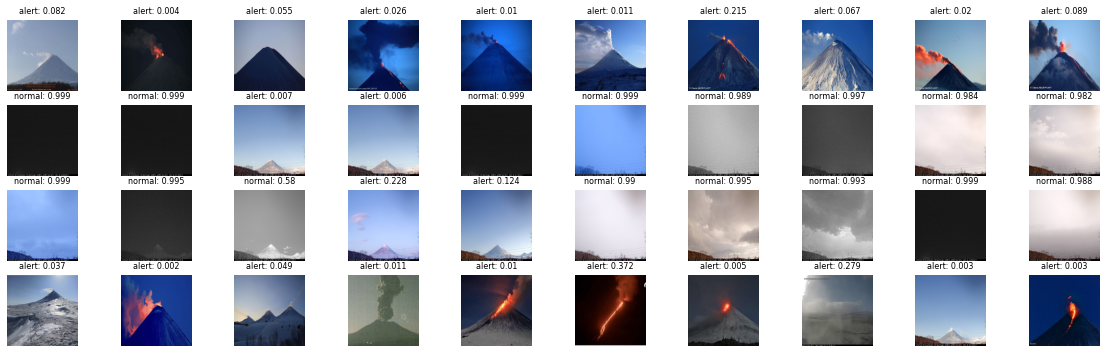

In [ ]:
show_images_predict(imagePaths_test,test_pred_VGG_model_status, 4,  10)

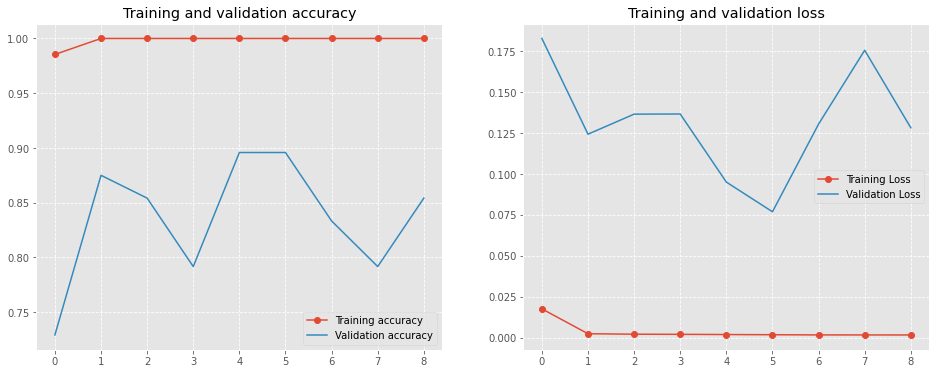

In [ ]:
plot_model_history(history_VGG_model_status)

In [ ]:
VGG_model_status.save(path.join(project_path,'models/VGG_model_status.h5'))

VGG19 без дополнительных слоев так же дает сходный результат. Но в спорной картинке это может быть хуже.

Самый лучший результат по метрикам loss и accuracy.Чувствительность низкая, на спорной картинке однозначно отнесено к классу(неверному)

## 4.2 Multiclass

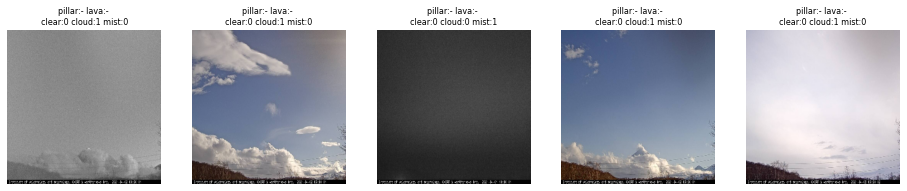

In [ ]:
show_images_gen_class(next(train_ds_classes),1,5)

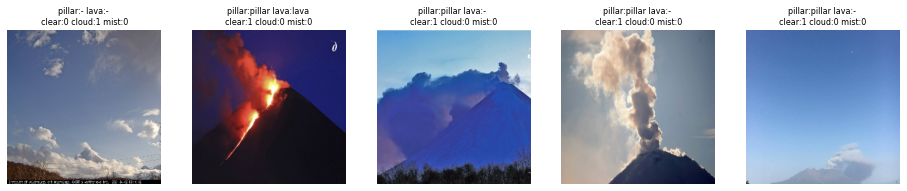

In [ ]:
show_images_gen_class(next(validation_ds_classes),1,5)

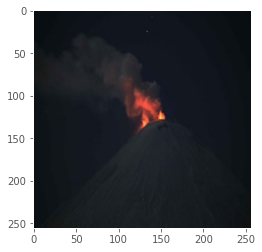

In [ ]:
plt.imshow(next(test_ds)[0])

### ResNet50 multiclass

In [67]:
base_model_ResNet = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3), classes=5) 

for layer in base_model_ResNet.layers:
    layer.trainable = False

x = base_model_ResNet.layers[-1].output

x = tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Dropout(.2, input_shape=(2,))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(5,  
                          activation='softmax',   
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

ResNet_model_multiclass =  tf.keras.Model(inputs = base_model_ResNet.input, outputs=x)

ResNet_model_multiclass.compile(optimizer='adam', loss=['mse','categorical_crossentropy'], metrics=['accuracy'])

Так как классы не сбалансированы и объединены в одну модель добавим веса.  Значимость классов выбросов больше чем класса видимости.

Оценка качества только кросс энтропии дает большую погрешность, добавляем MSE.

In [68]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

class_weights = {0: 1.5, 1: 3., 2: 0.2, 3: 0.3, 4: 0.8}

history_ResNet_model_multiclass = ResNet_model_multiclass.fit(train_ds, epochs=10, callbacks=[es_callback] , steps_per_epoch=10,  validation_data=validation_ds, validation_steps=3) 

Epoch 1/10
10/10 [==============================] - 9s 703ms/step - loss: 0.2992 - accuracy: 0.2313 - val_loss: 0.4089 - val_accuracy: 0.3750
Epoch 2/10
10/10 [==============================] - 6s 614ms/step - loss: 0.2814 - accuracy: 0.1715 - val_loss: 0.3601 - val_accuracy: 0.2917
Epoch 3/10
10/10 [==============================] - 6s 631ms/step - loss: 0.2702 - accuracy: 0.4490 - val_loss: 0.3760 - val_accuracy: 0.5139
Epoch 4/10
10/10 [==============================] - 6s 629ms/step - loss: 0.2540 - accuracy: 0.1304 - val_loss: 0.3678 - val_accuracy: 0.5694
Epoch 5/10
10/10 [==============================] - 6s 639ms/step - loss: 0.2566 - accuracy: 0.2045 - val_loss: 0.3528 - val_accuracy: 0.2917
Epoch 6/10
10/10 [==============================] - 6s 612ms/step - loss: 0.2689 - accuracy: 0.3036 - val_loss: 0.3759 - val_accuracy: 0.3056
Epoch 7/10
10/10 [==============================] - 6s 618ms/step - loss: 0.2710 - accuracy: 0.1291 - val_loss: 0.3181 - val_accuracy: 0.1528
Epoch 

In [69]:
test_pred_ResNet_model_multiclass = ResNet_model_multiclass.predict(predict_generator(imagePaths_test), steps=len(imagePaths_test))
test_pred_ResNet_model_multiclass

array([[0.19061203, 0.17226548, 0.17388038, 0.23296954, 0.23027252],
       [0.18211651, 0.19605175, 0.16853629, 0.22085802, 0.2324374 ],
       [0.1860737 , 0.18966489, 0.16149026, 0.24010523, 0.22266597],
       [0.21691379, 0.19979784, 0.11113022, 0.2783599 , 0.19379821],
       [0.15307908, 0.23455371, 0.18861228, 0.22807164, 0.19568327],
       [0.16948421, 0.21517533, 0.18841091, 0.22286499, 0.20406456],
       [0.17738137, 0.21134634, 0.19042858, 0.20998833, 0.21085535],
       [0.15887757, 0.2102362 , 0.16656734, 0.25136507, 0.21295384],
       [0.19227445, 0.22512819, 0.07818578, 0.3259268 , 0.17848478],
       [0.14369728, 0.23738283, 0.13526341, 0.27932245, 0.2043341 ],
       [0.20434445, 0.19533743, 0.19402324, 0.20815328, 0.19814159],
       [0.19992708, 0.2055173 , 0.19647346, 0.20365477, 0.19442743],
       [0.19749056, 0.19563499, 0.2112742 , 0.19788298, 0.19771731],
       [0.19784379, 0.19666979, 0.21057557, 0.20027524, 0.1946356 ],
       [0.20119274, 0.2035747 , 0.

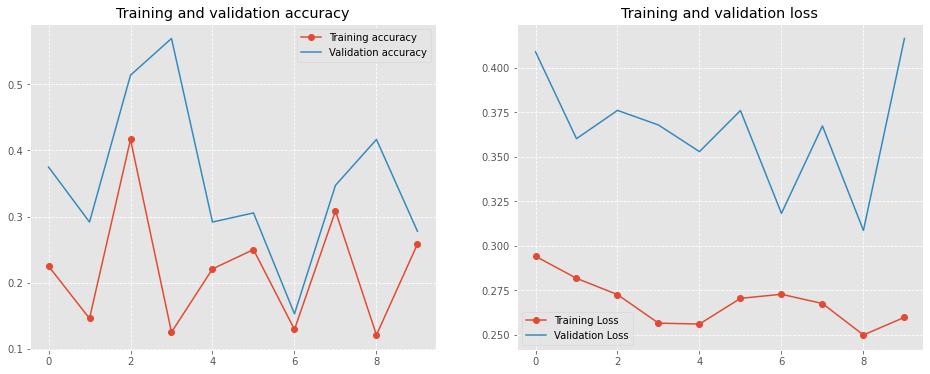

In [70]:
plot_model_history(history_ResNet_model_multiclass)

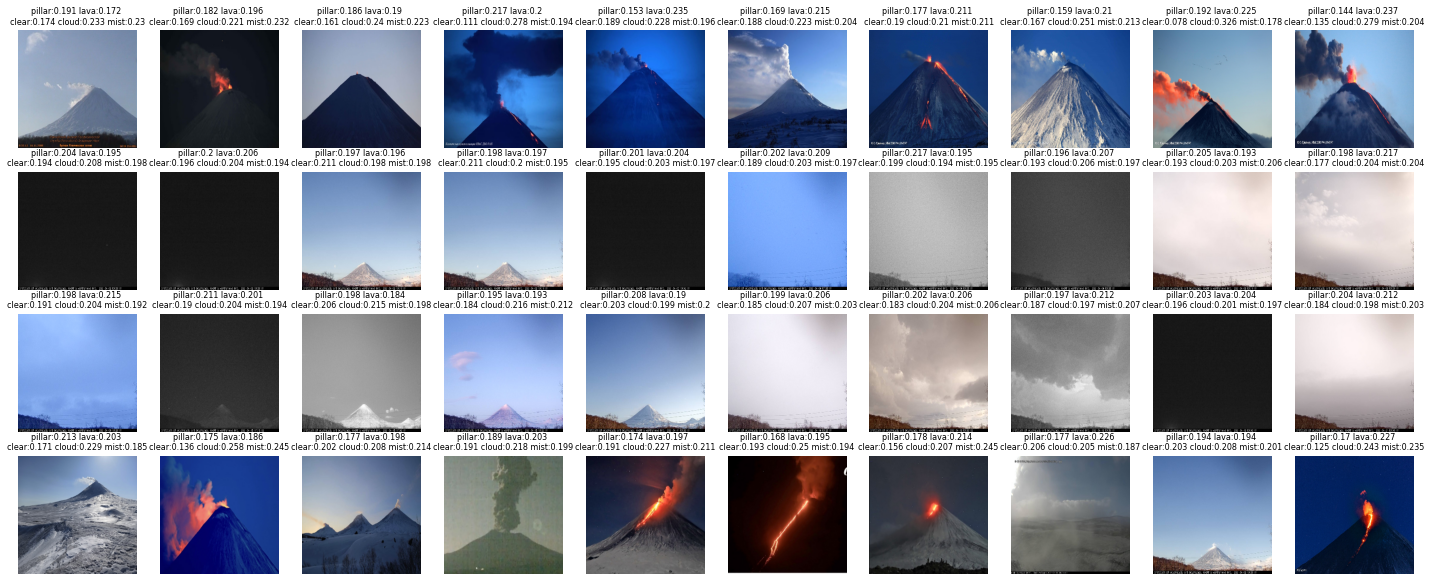

In [71]:
show_images_predict_class(imagePaths_test,test_pred_ResNet_model_multiclass, 4, 10)

In [ ]:
ResNet_model_multiclass.save(path.join(project_path,'models/resnet_multiclass_model.h5'))

### VGG multiclass

In [56]:
base_model_VGG = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3), classes=5) 

for layer in base_model_VGG.layers:
    layer.trainable = False


x = base_model_VGG.layers[-5].output
x = tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Dropout(.2, input_shape=(2,))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(5,  
                          activation='softmax', 
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

VGG_model_multiclass =  tf.keras.Model(inputs = base_model_VGG.input, outputs=x)

VGG_model_multiclass.compile(optimizer='adam', loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

class_weights = {0: 2.5, 1: 3., 2: 0.2, 3: 0.3, 4: 0.8}

history_VGG_model_multiclass = VGG_model_multiclass.fit(train_ds, epochs=10, steps_per_epoch=10, callbacks=[es_callback], class_weight = class_weights , validation_data=validation_ds, validation_steps=2)  


Epoch 1/10
10/10 [==============================] - 6s 601ms/step - loss: 0.9098 - accuracy: 0.1932 - val_loss: 0.4357 - val_accuracy: 0.0625
Epoch 2/10
10/10 [==============================] - 5s 580ms/step - loss: 0.7899 - accuracy: 0.1910 - val_loss: 0.4052 - val_accuracy: 0.0208
Epoch 3/10
10/10 [==============================] - 5s 591ms/step - loss: 0.8207 - accuracy: 0.2179 - val_loss: 0.5083 - val_accuracy: 0.0208
Epoch 4/10
10/10 [==============================] - 5s 584ms/step - loss: 0.8513 - accuracy: 0.1854 - val_loss: 0.3964 - val_accuracy: 0.1667
Epoch 5/10
10/10 [==============================] - 5s 586ms/step - loss: 0.7536 - accuracy: 0.1409 - val_loss: 0.3893 - val_accuracy: 0.0833
Epoch 6/10
10/10 [==============================] - 5s 586ms/step - loss: 0.7962 - accuracy: 0.1916 - val_loss: 0.3843 - val_accuracy: 0.2083
Epoch 7/10
10/10 [==============================] - 5s 593ms/step - loss: 0.7585 - accuracy: 0.2107 - val_loss: 0.3978 - val_accuracy: 0.4167
Epoch 

In [ ]:
VGG_model_multiclass.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0  

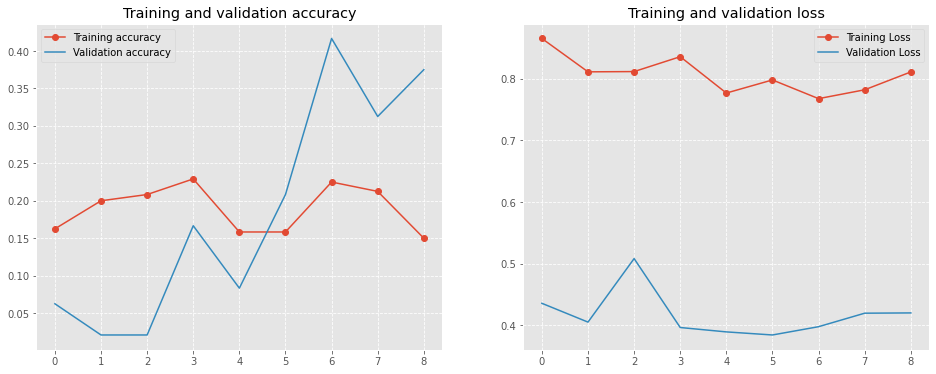

In [57]:
plot_model_history(history_VGG_model_multiclass)

In [58]:
test_pred_VGG_model_multiclass = VGG_model_multiclass.predict(predict_generator(imagePaths_test), steps=len(imagePaths_test))
test_pred_VGG_model_multiclass

array([[0.4205925 , 0.19300765, 0.1588628 , 0.0576796 , 0.16985746],
       [0.30980176, 0.15756817, 0.09040788, 0.12360858, 0.31861362],
       [0.53026575, 0.01815088, 0.0279476 , 0.00540211, 0.41823363],
       [0.4212992 , 0.25262272, 0.0553786 , 0.06154938, 0.20915009],
       [0.47904715, 0.0316193 , 0.08082818, 0.04025983, 0.36824554],
       [0.3883663 , 0.08052494, 0.1426066 , 0.06886214, 0.31964   ],
       [0.4219519 , 0.10536051, 0.10170212, 0.25517285, 0.11581273],
       [0.63251215, 0.05195611, 0.12604187, 0.09252144, 0.09696846],
       [0.7994461 , 0.01965388, 0.02583798, 0.02324778, 0.13181424],
       [0.56723964, 0.07016934, 0.11562972, 0.04415978, 0.20280156],
       [0.36874837, 0.30869794, 0.08789202, 0.14396553, 0.09069616],
       [0.40372396, 0.28937206, 0.08554679, 0.13671958, 0.08463753],
       [0.525292  , 0.23126154, 0.04576742, 0.08142436, 0.11625472],
       [0.5123209 , 0.232901  , 0.04782034, 0.08425464, 0.12270311],
       [0.40301013, 0.2873033 , 0.

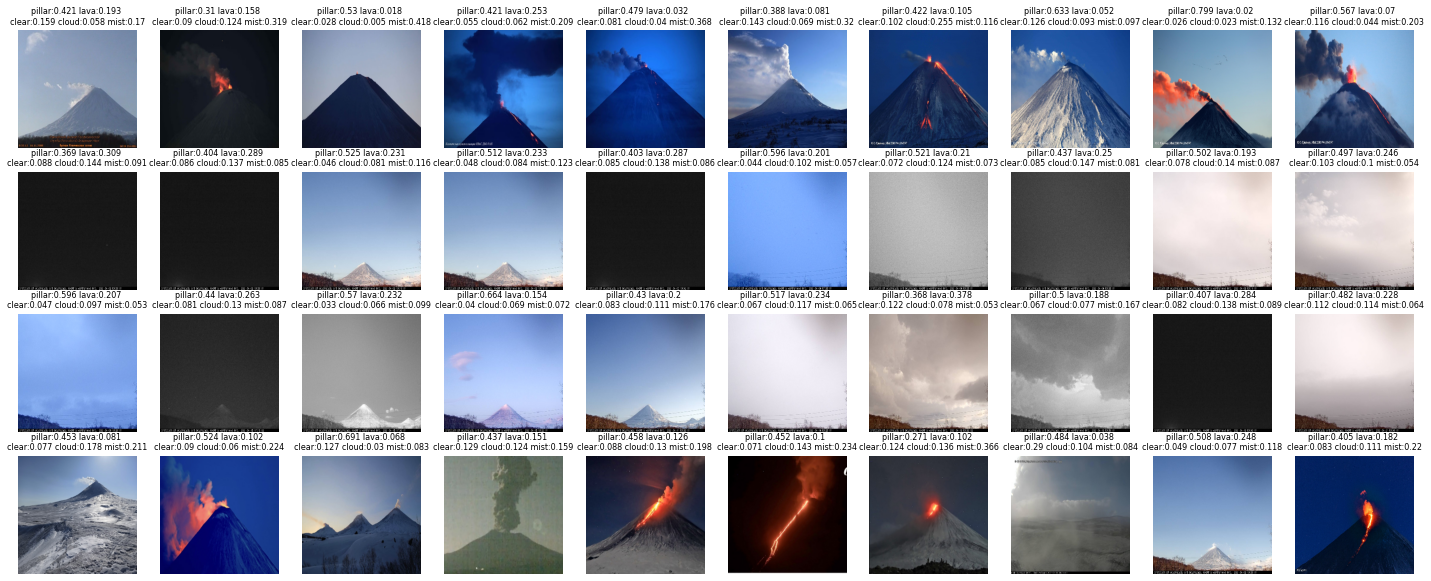

In [61]:
show_images_predict_class(imagePaths_test,test_pred_VGG_model_multiclass, 4,  10)

In [62]:
VGG_model_multiclass.save(path.join(project_path,'models/VGG_multiclass_model.h5'))

## 4.3 Оценка моделей

In [ ]:
classifiers = {
  #'clear_model' : history_model,
  'VGG': history_VGG,
  'VGG_model_status': history_VGG_model_status,
  'VGG_model_multiclass': history_VGG_model_multiclass,
  'ResNet_model': history_ResNet_model,
  'ResNet_model_status': history_ResNet_model_status,
  'ResNet_model_multiclass': history_ResNet_model_multiclass
}

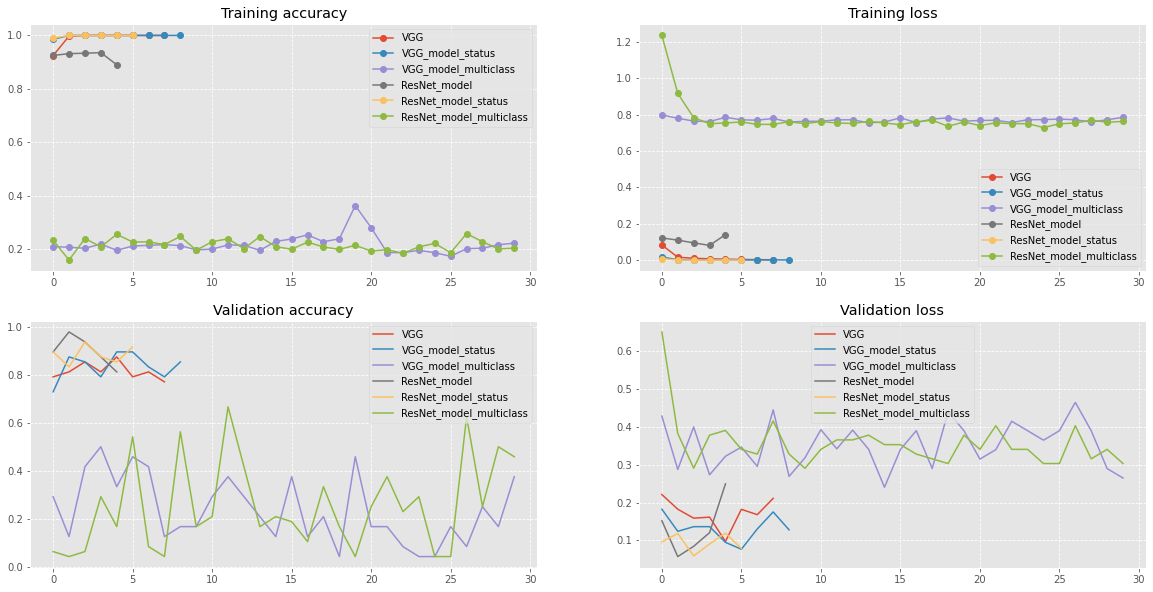

In [ ]:
# Getting the accuracy and loss
result_ml = pd.DataFrame()
fig = plt.figure(figsize=(20, 10))
for model_history in classifiers.items():
      acc = model_history[1].history['accuracy']
      val_acc = model_history[1].history['val_accuracy']
      loss = model_history[1].history['loss']
      val_loss = model_history[1].history['val_loss']
      
      result_ml = result_ml.append({'model' : 'NN',
                              'classifier' : model_history[0],
                              'val accuracy' : val_acc,
                              'train accuracy' : acc,
                              'train loss' : loss,
                              'val loss' : val_loss,
                              } ,  ignore_index=True)

      epochs = range(len(acc))

      subplot = fig.add_subplot(2, 2, 1)
      subplot.set_title('accuracy')
      plt.plot(epochs, acc, '-o', label=model_history[0])
      plt.title('Training accuracy')
      plt.legend()
      plt.grid(linestyle='--')

      subplot = fig.add_subplot(2, 2, 3)
      subplot.set_title('accuracy')
      plt.plot(epochs, val_acc, '-', label=model_history[0])
      plt.title('Validation accuracy')
      plt.legend()
      plt.grid(linestyle='--')

      subplot = fig.add_subplot(2, 2, 2)
      subplot.set_title('loss')
      plt.plot(epochs, loss, '-o', label=model_history[0] )
      plt.title('Training loss')
      plt.legend()
      plt.grid(linestyle='--')

      subplot = fig.add_subplot(2, 2, 4)
      subplot.set_title('loss')
      plt.plot(epochs, val_loss, '-', label=model_history[0])
      plt.title('Validation loss')
      plt.legend()
      plt.grid(linestyle='--')

plt.show()

In [ ]:
result_ml

classifier  ...                                           val loss
0                      VGG  ...  [0.22134172916412354, 0.18269093334674835, 0.1...
1         VGG_model_status  ...  [0.18266446888446808, 0.12427087873220444, 0.1...
2     VGG_model_multiclass  ...  [0.4486386477947235, 0.3525222837924957, 0.399...
3             ResNet_model  ...  [0.1522243767976761, 0.0575374998152256, 0.084...
4      ResNet_model_status  ...  [0.09623968601226807, 0.11853485554456711, 0.0...
5  ResNet_model_multiclass  ...  [0.3150049149990082, 0.3525052070617676, 0.340...

[6 rows x 6 columns]

In [104]:
test_pred_df = pd.DataFrame()
for i, p in enumerate(imagePaths_test, 0):
        test_pred_df = test_pred_df.append(
                              {'filename' : p.split(os.path.sep)[-1],
                              'image' : np.array(load_image(p)),
                              'pred_ResNet_model_status' : test_pred_ResNet_model_status.flatten()[i],
                              'pred_vgg_model_status' : test_pred_VGG_model_status.flatten()[i],
                              'pred_VGG_model_multiclass' : test_pred_VGG_model_multiclass[i],
                              'pred_ResNet_model_multiclass' :  test_pred_ResNet_model_multiclass[i]
                               } ,  ignore_index=True)

In [105]:
test_pred_df.head(1)

filename  ... pred_vgg_model_status
0  1102.jpg  ...              0.082341

[1 rows x 6 columns]

In [88]:
y_test_pred_df = test_pred_df
y_test_pred_df = y_test_pred_df.drop(columns=['image'])

In [ ]:
y_test_pred_df.to_csv('predict.csv')

In [89]:
status = [0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1]


In [103]:
y_true = status 
y_pred = test_pred_df['pred_ResNet_model_status']


print('F1 : %s' % f1_score(y_true, y_pred.round(), average='weighted'))
print('Precision : %s' % precision_score(y_true, y_pred.round(), average='weighted')) 
print('Accuracy: %s' % accuracy_score(y_true, y_pred.round()))
print('Recall: %s' % recall_score(y_true, y_pred.round()))
confusion_matrix(y_true,  y_pred.round())

F1 : 0.8892187585903569
Precision : 0.8974527887571365
Accuracy: 0.8888888888888888
Recall: 0.84


array([[19,  1],
       [ 4, 21]])

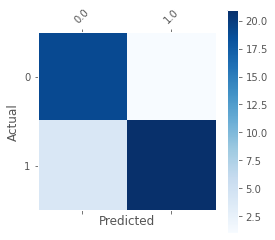

In [99]:
y_true = pd.Series(y_true, name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_true, y_pred.round())
plot_confusion_matrix(df_confusion)

In [113]:
y_true = status 
y_pred = test_pred_df['pred_vgg_model_status']


print('F1 : %s' % f1_score(y_true, y_pred.round(), average='weighted'))
print('Precision : %s' % precision_score(y_true, y_pred.round(), average='weighted')) 
print('Accuracy: %s' % accuracy_score(y_true, y_pred.round()))
print('Recall: %s' % recall_score(y_true, y_pred.round()))
confusion_matrix(y_true,  y_pred.round())

F1 : 0.9112867808519982
Precision : 0.925925925925926
Accuracy: 0.9111111111111111
Recall: 0.84


array([[20,  0],
       [ 4, 21]])

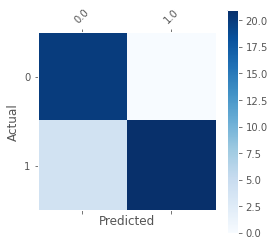

In [114]:
y_true = pd.Series(y_true, name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_true, y_pred.round())
plot_confusion_matrix(df_confusion)

In [109]:
multiclass = [[1,	0,	1,	0,	0],[1,	1,	1,	0,	0],[0,	1,	1,	0,	0],[1,	1,	1,	0,	0],[1,	1,	1,	0,	0],[1,	0,	1,	0,	0],[1,	1,	1,	0,	0],[1,	0,	1,	0,	0],[1,	0,	1,	0,	0],[1,	1,	1,	0,	0],[0,	0,	0,	0,	1],[0,	0,	0,	0,	1],[0,	0,	1,	0,	0],[1,	0,	1,	0,	0],[0,	0,	0,	0,	1],[0,	0,	0,	0,	1],[0,	0,	0,	0,	1],[0,	0,	0,	0,	1],[0,	0,	0,	0,	1],[0,	0,	1,	0,	0],[0,	0,	1,	0,	0],[0,	0,	1,	0,	0],[0,	0,	1,	0,	0],[0,	0,	1,	0,	0],[0,	0,	1,	0,	0],[0,	0,	0,	0,	1],[0,	0,	0,	1,	0],[0,	0,	0,	1,	0],[0,	0,	0,	0,	1],[0,	0,	0,	0,	1],[1,	0,	1,	0,	0],[1,	1,	1,	0,	0],[1,	0,	1,	0,	0],[1,	0,	1,	0,	0],[1,	1,	1,	0,	0],[1,	1,	1,	0,	0],[0,	1,	1,	0,	0],[1,	0,	0,	1,	0],[1,	0,	1,	0,	0],[1,	1,	1,	0,	0],[0,	0,	0,	1,	0],[0,	0,	1,	0,	0],[0,	0,	1,	0,	0],[0,	0,	0,	1,	0],[0,	0,	0,	0,	1]]

In [ ]:
multiclass_df = pd.DataFrame(multiclass)

pred_df = pd.DataFrame(test_pred_df['pred_ResNet_model_multiclass'].to_list()).round()
pred_df

In [173]:
y_true = multiclass_df[0]
y_pred = pred_df[0]

In [177]:
y_true = multiclass_df[0]
y_pred = pred_df[0]
print('F1 : %s' % f1_score(y_true, y_pred.round(), average='weighted'))
print('Precision : %s' % precision_score(y_true, y_pred.round(), average='weighted')) 
print('Accuracy: %s' % accuracy_score(y_true, y_pred.round()))
print('Recall: %s' % recall_score(y_true, y_pred.round()))
y_true = multiclass_df[1]
y_pred = pred_df[1]
print('F1 : %s' % f1_score(y_true, y_pred.round(), average='weighted'))
print('Precision : %s' % precision_score(y_true, y_pred.round(), average='weighted')) 
print('Accuracy: %s' % accuracy_score(y_true, y_pred.round()))
print('Recall: %s' % recall_score(y_true, y_pred.round()))
y_true = multiclass_df[2]
y_pred = pred_df[2]
print('F1 : %s' % f1_score(y_true, y_pred.round(), average='weighted'))
print('Precision : %s' % precision_score(y_true, y_pred.round(), average='weighted')) 
print('Accuracy: %s' % accuracy_score(y_true, y_pred.round()))
print('Recall: %s' % recall_score(y_true, y_pred.round()))
y_true = multiclass_df[3]
y_pred = pred_df[3]
print('F1 : %s' % f1_score(y_true, y_pred.round(), average='weighted'))
print('Precision : %s' % precision_score(y_true, y_pred.round(), average='weighted')) 
print('Accuracy: %s' % accuracy_score(y_true, y_pred.round()))
print('Recall: %s' % recall_score(y_true, y_pred.round()))
y_true = multiclass_df[4]
y_pred = pred_df[4]
print('F1 : %s' % f1_score(y_true, y_pred.round(), average='weighted'))
print('Precision : %s' % precision_score(y_true, y_pred.round(), average='weighted')) 
print('Accuracy: %s' % accuracy_score(y_true, y_pred.round()))
print('Recall: %s' % recall_score(y_true, y_pred.round()))

F1 : 0.42316118935837244
Precision : 0.3338271604938271
Accuracy: 0.5777777777777777
Recall: 0.0
F1 : 0.6503516174402251
Precision : 0.5708641975308643
Accuracy: 0.7555555555555555
Recall: 0.0
F1 : 0.18652094717668488
Precision : 0.12641975308641976
Accuracy: 0.35555555555555557
Recall: 0.0
F1 : 0.8366013071895425
Precision : 0.7901234567901235
Accuracy: 0.8888888888888888
Recall: 0.0
F1 : 0.6503516174402251
Precision : 0.5708641975308643
Accuracy: 0.7555555555555555
Recall: 0.0


# Deployment

Обработка входного изображения и выдача результата:

In [72]:

ResNet_model_status= tf.keras.models.load_model(path.join(project_path,'models/resnet_model_status.h5'))
VGG_model_status= tf.keras.models.load_model(path.join(project_path,'models/VGG_model_status.h5'))

ResNet_model_multiclass = tf.keras.models.load_model(path.join(project_path,'models/resnet_multiclass_model.h5'))
VGG_model_multiclass = tf.keras.models.load_model(path.join(project_path,'models/VGG_multiclass_model.h5'))



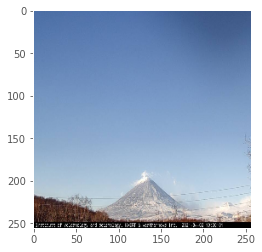

Predictions probabilities Resnet - VGG: 
status class
0-alert/1-normal -  0.002 -  0.003

activity class
pillar -  0.194 -  0.508
lava   -  0.194 -  0.248

visible class
clear -  0.203 -  0.049
cloud -  0.208 -  0.077
mist  -  0.201 -  0.118


In [83]:
imagePaths = [path.join(project_path,'data/raw/img/img.jpg')]
images_ds = predict_generator(imagePaths)

y_pred_resnet_status = ResNet_model_status.predict(images_ds, steps=len(imagePaths))
y_pred_vgg_status = VGG_model_status.predict(images_ds, steps=len(imagePaths))

y_pred_resnet = ResNet_model_multiclass.predict(images_ds, steps=len(imagePaths))
y_pred_vgg = VGG_model_multiclass.predict(images_ds, steps=len(imagePaths))


for i in range(len(imagePaths)): 
  plt.imshow(load_image(imagePaths[i]), cmap='gray');
  plt.show()
  prob_resnet_status = y_pred_resnet_status[i] 
  prob_vgg_status = y_pred_vgg_status[i] 
  prob_resnet = y_pred_resnet[i] 
  prob_vgg = y_pred_vgg[i] 
  print('Predictions probabilities Resnet - VGG: \nstatus class')
  print('0-alert/1-normal - ',np.round(prob_resnet_status[0],3),'- ',np.round(prob_vgg_status[0],3))
  print('\nactivity class')
  print('pillar - ',np.round(prob_resnet[0],3),'- ',np.round(prob_vgg[0],3))
  print('lava   - ',np.round(prob_resnet[1],3),'- ',np.round(prob_vgg[1],3))
  print('\nvisible class')
  print('clear - ',np.round(prob_resnet[2],3),'- ',np.round(prob_vgg[2],3))
  print('cloud - ',np.round(prob_resnet[3],3),'- ',np.round(prob_vgg[3],3))
  print('mist  - ',np.round(prob_resnet[4],3),'- ',np.round(prob_vgg[4],3))

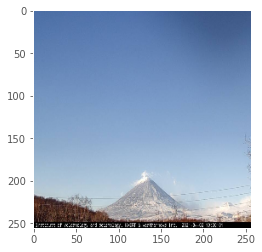

Predictions probabilities Resnet - VGG: 
status class
0-alert/1-normal -  0.002 -  0.003

activity class
pillar -  0.194 -  0.405
lava   -  0.194 -  0.182

visible class
clear -  0.203 -  0.083
cloud -  0.208 -  0.111
mist  -  0.201 -  0.22


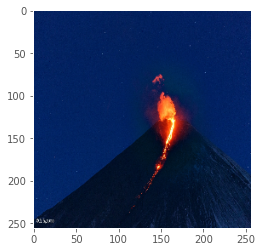

Predictions probabilities Resnet - VGG: 
status class
0-alert/1-normal -  0.002 -  0.003

activity class
pillar -  0.17 -  0.508
lava   -  0.227 -  0.248

visible class
clear -  0.125 -  0.049
cloud -  0.243 -  0.077
mist  -  0.235 -  0.118


In [84]:
imagePaths = [path.join(project_path,'data/raw/img/img.jpg'),path.join(project_path,'data/raw/img/img2.jpg')]
images_ds = predict_generator(imagePaths)

y_pred_resnet_status = ResNet_model_status.predict(images_ds, steps=len(imagePaths))
y_pred_vgg_status = VGG_model_status.predict(images_ds, steps=len(imagePaths))

y_pred_resnet = ResNet_model_multiclass.predict(images_ds, steps=len(imagePaths))
y_pred_vgg = VGG_model_multiclass.predict(images_ds, steps=len(imagePaths))

for i in range(len(imagePaths)): 
  plt.imshow(load_image(imagePaths[i]), cmap='gray');
  plt.show()
  prob_resnet_status = y_pred_resnet_status[i] 
  prob_vgg_status = y_pred_vgg_status[i] 
  prob_resnet = y_pred_resnet[i] 
  prob_vgg = y_pred_vgg[i] 
  print('Predictions probabilities Resnet - VGG: \nstatus class')
  print('0-alert/1-normal - ',np.round(prob_resnet_status[0],3),'- ',np.round(prob_vgg_status[0],3))
  print('\nactivity class')
  print('pillar - ',np.round(prob_resnet[0],3),'- ',np.round(prob_vgg[0],3))
  print('lava   - ',np.round(prob_resnet[1],3),'- ',np.round(prob_vgg[1],3))
  print('\nvisible class')
  print('clear - ',np.round(prob_resnet[2],3),'- ',np.round(prob_vgg[2],3))
  print('cloud - ',np.round(prob_resnet[3],3),'- ',np.round(prob_vgg[3],3))
  print('mist  - ',np.round(prob_resnet[4],3),'- ',np.round(prob_vgg[4],3))



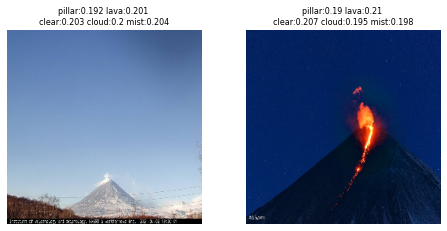

In [ ]:
show_images_predict_class(imagePaths,y_pred_resnet, 6,  6)

In [ ]:
y_pred_resnet_df = pd.DataFrame(y_pred_resnet)
y_pred_resnet_df


0         1         2         3         4
0  0.192118  0.201482  0.202710  0.199989  0.203702
1  0.190343  0.209778  0.207184  0.194749  0.197946